In [1]:
#load spectroscopic Albert_Data from 2019-02-25, 2019-01-28 
#also look at data collected in Data 2019-10-17

#work all approaches
    #cut kappa to make it look like a line
    #take best from before and best from after 
    #compare

    #dont divide
    #make simulated LIY the same as the Nanonis LIY

In [2]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib

import scipy.fftpack as fftp
import os

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Geophone Scan 2019-01-28

In [3]:
#load data into 1 array 
#automate the seperation for calibration 
folder_loc = 'Albert_Data/2019-01-28/'
file_loc = '2019-01-28-geophone-scan'

dat = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=137)
dat_stmpy = stmpy.load(folder_loc+file_loc+'001'+'.dat')

for j in arange(2,362):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
#         temp_dat = stmpy.load(folder_loc+file)
        temp_dat = np.loadtxt(file, skiprows=137)
        dat = np.concatenate((dat,temp_dat))
        print(j,end='\r')
    except:
        pass

File import successful.
ERR: File not in standard format for processing. Could not correct for Bias offset


In [4]:
# A function that returns array with the n-th degree polynomial background removed. 
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

# Same implementation as in cancelv3.py. but with any given transfer function/frequencies.
# Useful when storing a transfer function as a 2D array of complex numbers/frequencies.
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

# low pass filter with a cutoff frequency equivalent to n samples.
def lpfilter(array,n):
    return repeat(mean(array.reshape(-1,n),axis=1),n)

# Divide by mean
def normalize(array):
    return array/mean(array)

# Subtract mean and divide by range.
def normalize2(array):
    return (array-mean(array))/(max(array) - min(array))

In [5]:
test = list(dat_stmpy.channels.keys())
print(test)

['Current (A)', 'InternalGeophone (V)', 'Bias (V)', 'BiasModulationCh. (V)', 'X (m)', 'Y (m)', 'Z (m)', 'LI Demod 1 X (A)', 'LI Demod 1 Y (A)']


In [6]:
folder_loc = 'Data/2019-10-17/'
file_loc = '2019-10-17 Calibration spec A'

dat_cal = np.loadtxt(folder_loc+file_loc+'001'+'.dat',skiprows=119)
count = 1
for j in arange(2,290):
    file = folder_loc+file_loc+str(j).zfill(3)+'.dat'
    try:
        temp_dat = np.loadtxt(file,skiprows=119)
        dat_cal = np.concatenate((dat_cal,temp_dat))
    except:
        pass
cur_cal2 = dat_cal[:,0]
geo_cal2 = dat_cal[:,1]
tip_cal2 = dat_cal[:,2]
lix_cal2 = dat_cal[:,3]
liy_cal2 = dat_cal[:,4]
print(len(geo_cal2))

7203000


(0, 0.1)

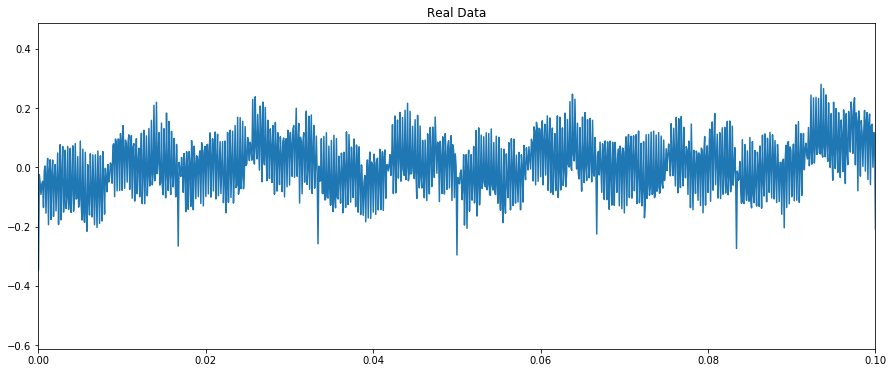

In [7]:
figsize(15,6)

calibration_length = int(0.8*len(dat))

cur_cal = dat[:calibration_length,0]
SRS_cal = dat[:calibration_length,1]
geo_cal = dat[:calibration_length,2]
bias_cal = dat[:calibration_length,3]
x_cal = dat[:calibration_length,4]
y_cal = dat[:calibration_length,5]
tip_cal = dat[:calibration_length,6]
lix_cal = dat[:calibration_length,7]
liy_cal = dat[:calibration_length,8]

cur = dat[calibration_length:,0]
SRS = dat[calibration_length:,1]
geo = dat[calibration_length:,2]
bias = dat[calibration_length:,3]
x = dat[calibration_length:,4]
y = dat[calibration_length:,5]
tip = dat[calibration_length:,6]
lix = dat[calibration_length:,7]
liy = dat[calibration_length:,8]

# log fitting on Z spectroscopiy data to get kappa (fit[0])
foldername='Albert_Data/2019-02-25/'

i=1
z_spec=loadtxt(foldername+'Z-Spectroscopy-noisy001.dat',skiprows=62)
fit = polyfit(z_spec[:,0],log(abs(z_spec[:,1])),1)
t = linspace(0,len(SRS_cal)/10000,len(SRS_cal))
plot(t,normalize2(SRS_cal))
# plot(t,normalize2(tip_cal))
title('Real Data')
xlim(0,0.1)

Text(0.5, 1.0, 'Real Data')

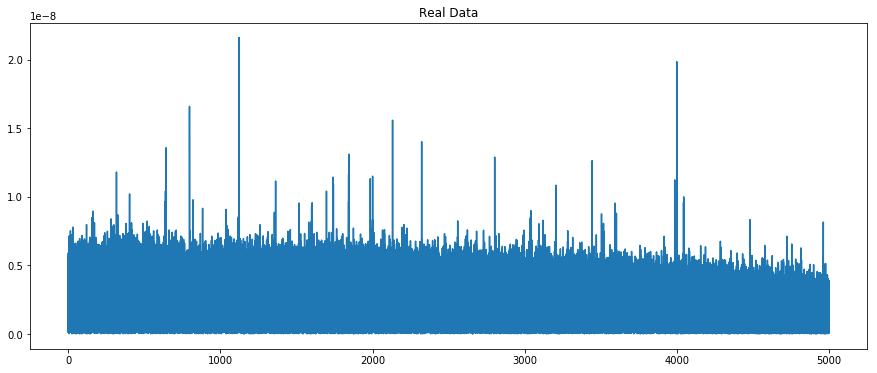

In [8]:
ft = np.fft.fft(SRS_cal)
tipfft = np.fft.fft(lix_cal)
freq = np.fft.fftfreq(len(geo),1/10000)
# plot(freq[:100000],abs(ft[:100000]))
plot(freq[:int(len(freq)/2)],abs(tipfft[:int(len(freq)/2)]))
title('Real Data')
# xlim(1,1000)
# xlim(10,50)

### Lick in repliction

In [9]:
# load data
file_name = "lock-in-test"
folder_name = "Albert_Data/Sim Data/"

i = 1
temp_data = np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=7)
# os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
while True:
    i += 1
    try:
        temp_data = np.concatenate((temp_data, np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=7)))
        # os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
    except:
        break
        
cur_temp = temp_data[:,0]
v_temp = temp_data[:,1]
lix_temp = temp_data[:,2]
liy_temp = temp_data[:,3]

[-2.92835925e-26-6.81672491e-42j -2.92835925e-26+1.17963891e-41j
 -2.92835925e-26-1.52532530e-41j ... -2.92835925e-26+2.27206662e-42j
 -2.92835925e-26-3.63327198e-42j -2.92835925e-26+1.05328764e-41j]


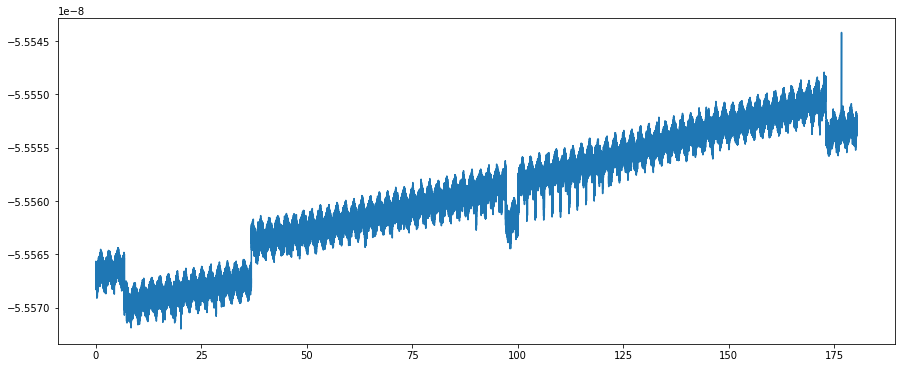

In [10]:
figsize(15,6)
t = linspace(0,len(cur)/10000,len(cur))
trx = cancel.Cancel(geo_cal-mean(geo_cal), tip_cal-mean(tip_cal), 1/10000,p=[200000,50000,5])
z_noise = trx.create_drive(geo-mean(geo))
print(z_noise)
plot(t,tip)
# plot(t,tip-z_noise)

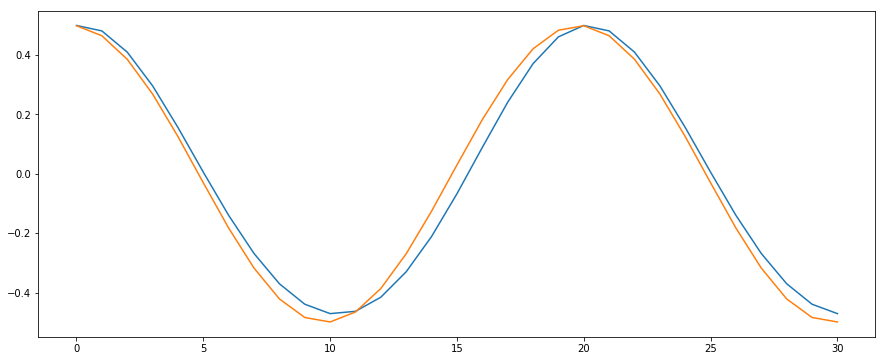

In [11]:
figsize(15,6)
#Why is there a 19 unit delay btw v and current?
#Data logger, comes to be about 0.0019 sec
a = 19
v_ac = v_temp - mean(v_temp)
plot(20000000*(cur_temp[:50-a]-mean(cur_temp[:50-a])))
plot(v_ac[a:50])

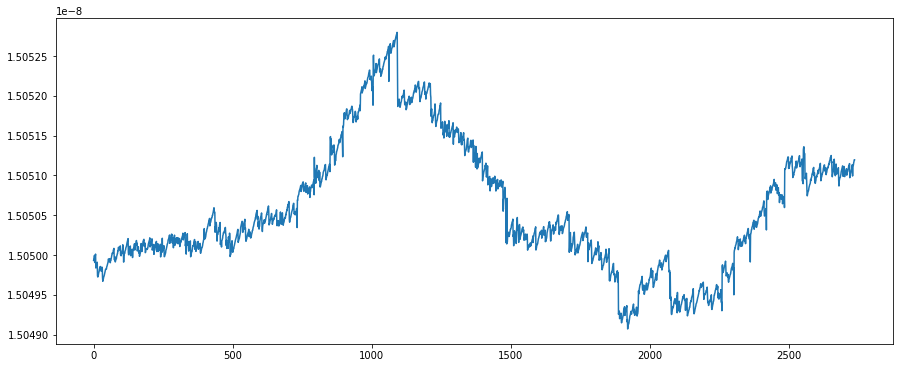

In [12]:
figsize(15,6)
a=19
v_ac = v_temp-mean(v_temp) # removes V_DC and only considers V_AC

#How is this found? Experimentally? Lock in operates around 1kHz?
coefficient = 1250/10000 # This term is supposed to be 1/T, where T is lock-in period. 
                         #     However, this does not match the Nanonis output.
lix_calc = coefficient*sum((cur_temp[:-a]*v_ac[a:])[:54760].reshape(-1, 20), axis=1) # this calculation replicates the lock-in integral
plot(lix_calc)
#plot(lix_temp[::20])

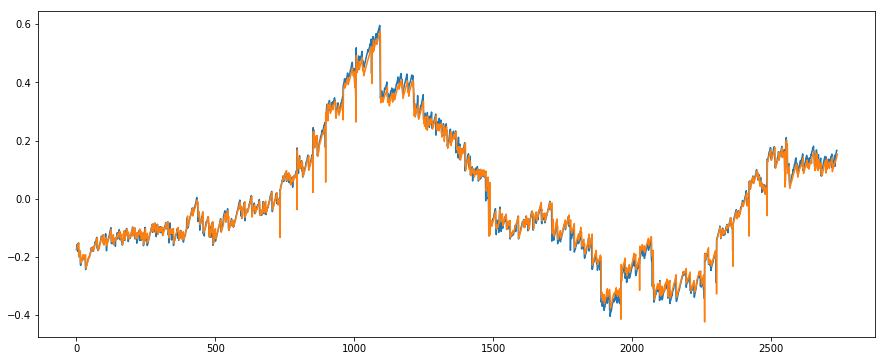

In [13]:
figsize(15,6)
plot(normalize2(lix_calc))
plot(normalize2(lix_temp[::20]))

# Exact Cancellation 

In [14]:
nc = cancel.Cancel(geo_cal2,tip_cal2,1/10000,p=[150000,100000,5])
transf = nc.transf
freqs = nc.freqs
z_noise = create_drive(geo,1/10000,transf,freqs)
cur_noise = exp(-(z_noise-mean(z_noise))*fit[0])

C:\Users\jgoet\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


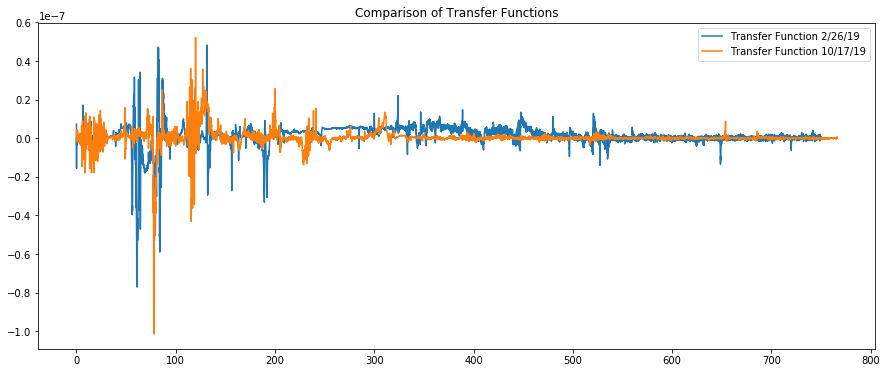

In [15]:
figsize(15,6)
[transf_Alb, freqs_Alb] = joblib.load('Albert_Data/2019-02-26/trx2_v2') # load a previously calibrated transfer function
plot(freqs_Alb[:15000],transf_Alb(freqs_Alb[:15000]),label='Transfer Function 2/26/19')
plot(freqs[:11500],transf(freqs[:11500]),label='Transfer Function 10/17/19')
title('Comparison of Transfer Functions')
legend()

(0, 40)

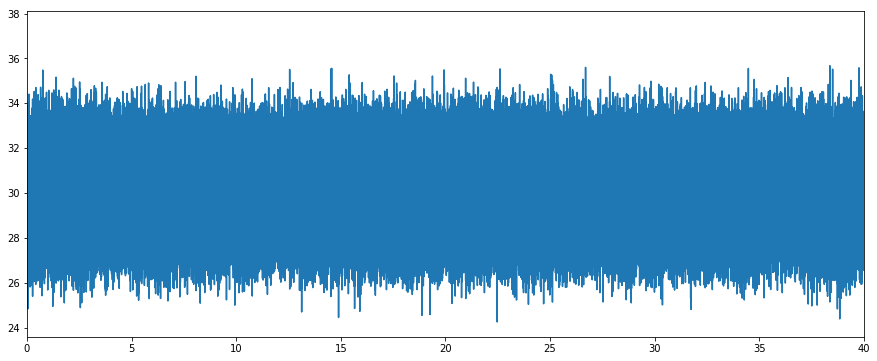

In [16]:
figsize(15,6)
t = linspace(0,len(cur)/10000,len(cur))
cur_correct = cur/cur_noise*1e12

plot(t,cur*1e12)
# plot(t,cur_correct)
xlim(0,40)

(0, 40)

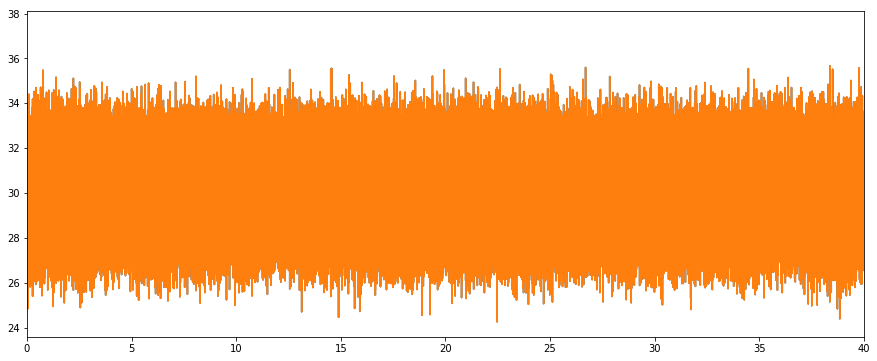

In [17]:
figsize(15,6)
z_noise2 = create_drive(geo,1/10000,transf_Alb,freqs_Alb)
cur_noise2 = exp(-(z_noise2-mean(z_noise2))*fit[0])

cur_correct2 = cur/cur_noise2

plot(t,cur*1e12)
plot(t,cur_correct2*1e12)
xlim(0,40)

# Z-LIY

ValueError: cannot reshape array of size 1803634 into shape (8)

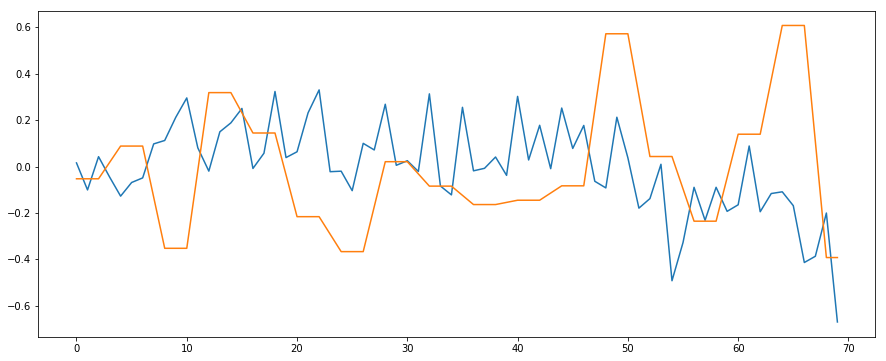

In [18]:
figsize(15,6)
plot(normalize2(cur_noise[30:100]),label='Current Noise')
plot(normalize2(liy[0:70]),label='LIY')

noise_calc = repeat(mean(cur_noise[:-6].reshape(-1,8),axis=1),8)
correction = liy[:-36]/noise_calc[30:]

plot(normalize2(noise_calc[30:100]),label='Averaged Current Noise')
plot(normalize2(correction[0:70]),label='Corrected LIY')
legend()

In [ ]:
figsize(15,6)
#prove mathematically 

plot(t,liy*1e12)
#what is the point of averaging every 8 data points
#why is there a delay between liy and cur_noise
delay=30
plot(t[:-delay],liy[:-delay]/cur_noise2[delay:]*1e12)
plot(t[:-delay],liy[:-delay]/(repeat(mean(cur_noise2[delay:].reshape(-1,8),axis=1),8))*1e12)

# G-LIY

In [ ]:
figsize(15,6)
liy_transf = cancel.Cancel(geo_cal-mean(geo_cal),fit_cancel(liy_cal-mean(liy_cal)),1/10000,p=[200000,50000,5])
liy_noise = liy_transf.create_drive(geo-mean(geo))

plot(t,liy*1e12)
plot(t,liy*1e12-liy_noise*1e12)
xlim(0,40)

# G-log(LIY)

In [ ]:
log_transf = cancel.Cancel(geo_cal-mean(geo_cal),log(liy_cal),1/10000,p=[200000,50000,5])
log_noise = log_transf.create_drive(geo-mean(geo))

plot(t,liy*1e12)
# plot(t,normalize2((liy)-exp(log_noise)*1e12))
plot(t,(exp(log(liy)-log_noise)*1e12))

xlim(0,40)